# Strained Crystal Structure Generator

Welcome to the strained crystal structure generator! This notebook just generates a bunch of strained crystal structure unit cells to your specifications. You can either use it to generate one unit cell or a range of unit cells.

To replicate the things done within this notebook, you will need to install Quantum ESPRESSO, as well as numpy, seaborn, and pandas. You will want to keep the last packages in a separate environment. To install QE, create a fresh Conda environment and then use this command: 

conda install -c conda-forge qe

Note that QE works best on a fresh environment from my experience. Sometimes, running jupyter notebooks from QE's environment may not work.

To calculate crystal structure energies, you should also set up a directory containing the necessary directories and files.

There is a specific way you should set up your directory. You should keep all of your directories within a main directory. Within this main directory, you should have a directory called "pseudo", one called "tmp", and one called "po" (or whatever atomic crystal you are interested in). This directory structure is also detailed in the README.

Within the "po" directory, you should have this jupyter notebook. Within the "pseudo" directory, you should have pseudopotentials for whatever species are in your crystal of interest. They are needed for unit cell energy calculations. These pseudpotentials can be found at http://pseudopotentials.quantum-espresso.org/legacy_tables

The "tmp" directory can remain empty initially. It's just for storing temporary files. You don't need to worry about it.

The way to use Quantum ESPRESSO to calculate the energy of these crystal structures is done by following this method:

- Navigate to the directory named after your atomic crystal is named after. In this case, ours would be "po."
- Type in pw.x -in [input_filename].in > [input_filename].out and wait for QE to do the calcs!
- Look at the .out file and find the bottommost "total energy". That is your unit cell energy.

If you're confused or want to know more, you can always refer the PWscf tutorial from the QE website itself: http://www.fisica.uniud.it/~giannozz/QE-Tutorial/

When you get to the website, just go to this bullet point: "Using PWscf: basics (write-up, exercises, March 2018)" and click on the "write-up" link. It will download a PDF tutorial, and that will teach you all the basics. If you do do their tutorial, make sure to also click on "exercises" to download the files for their tutorial if you do choose to do it. 

However, it should be more than enough to just follow through this notebook, as I've tried to document all that you need to do!

How do we generate the input files? Well, you're in luck, friend. I've written the code snippets just below, and reading through this, you should be able to not just generate your input files but also understand the goals and theory behind this project.

If you're still confused about the input files, you can always look at the write-up from the tutorial above.

In [1]:
import numpy as np
import math

Here, we are straining the originally simple cubic Po crystal unit cell to see how it changes in energy as a result. My goal here is to do a grid search and strain both the angles and the edge lengths. However, the angles between the verticies and the edge lengths will remain equivalent, even if they do vary, and the strained structure will essentially be a rhombohedral structure (edge lengths and angles same, but not all will be 90 degrees; see below for an image).

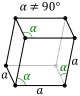

In [2]:
#Image from https://pyxtal.readthedocs.io/en/latest/Background.html
from IPython.display import Image
Image(filename='rhombohedral.png') 

The expected result is to see a bit of a funnel, sort of like a protein folding funnel, when we plot the energies. (I.e., As the crystal structure is strained away from its actual structure, it gets higher and higher in energy.) This is meant to be a bit of a proof of concept of evolutionary algorithms; if evolutionary algorithms work, then the structures should converge towards the real structure as the energy is lowered and vice versa. If confused, it's helpful to think back to protein folding funnels, only this is a crystal straining funnel.

The original unit cell dimensions for the unit cell I did my calculations for can be found at http://www.aflow.org/prototype-encyclopedia/A_cP1_221_a.html

Note that their edge lengths are in angstroms while QE wants them in au; you need to convert between the two. 

When I did my presentation initially, I mistakenly did my calculations in angstroms, so the number was smaller, and the calculations were shorter/easier on my computer. You actually need to convert to au before, which makes your edge length larger than the number you would find on the website. In my case, 3.34 angstroms become 6.3116848019 au.

In [2]:
#This function below writes the input file for PWscf for one set of edge lengths and angles.
#Edge lengths are in au, and the angles are actually the cosines of your desired angle.
#The filename format contains information about both the edge length and the angle of your
#rhombohedral unit cell as it directly contains the values of them.
#An example of what an input file should look like is posted in markdown below this.
#edge: edge length of rhombohedral unit cell in au
#ang: angle of rhombohedral unit cell in degrees
def write_file(edge, ang):
    #Generate filename. Includes the edge length after ".edge" and the angle after ".angle".
    fname = "po.scf.edge" + str(edge) + ".angle" + '{:.4f}'.format(ang) +  ".in"
    f = open(fname, 'w')
    #Array containing text lines for the input file. 
    text = [" &control\n", "    prefix=\'po\'\n", "    outdir=\'../tmp\'\n",
           "    pseudo_dir = \'../pseudo\',\n", " /\n", " &system    \n"
            "    ibrav=  5, celldm(1) = " + str(edge) + ", celldm(4) = " + '{:.4f}'.format(ang) + ", nat=  1, ntyp= 1,\n",
           "    ecutwfc =75.0,\n", "    occupations='smearing', smearing='marzari-vanderbilt', degauss=0.06\n",
           " /\n", " &electrons\n", " /\n", "ATOMIC_SPECIES\n", " Po  209.0 Po.pbe-dn-rrkjus_psl.1.0.0.UPF\n",
           "ATOMIC_POSITIONS alat\n", " Po 0.00 0.00 0.00 \n", "K_POINTS automatic\n", "  10 10 10 0 0 0\n"]
    f.writelines(text)
    f.close()
    return

Input file example contents:
<br>
 &control
 <br>
    prefix='po'
    <br>
    outdir='../tmp'
    <br>
    pseudo_dir = '../pseudo',
    <br>
 /
 <br>
 &system    
 <br>
    ibrav=  5, celldm(1) = 6.3116848019, celldm(4) = 0, nat=  1, ntyp= 1,
    <br>
    ecutwfc =75.0,
    <br>
    occupations='smearing', smearing='marzari-vanderbilt', degauss=0.06
    <br>
 /
 <br>
 &electrons
 <br>
 /
 <br>
ATOMIC_SPECIES
<br>
 Po  209.0 Po.pbe-dn-rrkjus_psl.1.0.0.UPF
 <br>
ATOMIC_POSITIONS alat
<br>
 Po 0.00 0.00 0.00
 <br>
K_POINTS automatic
<br>
  10 10 10 0 0 0
  
<br>
Some notes about what these mean in these input files.
<br>
prefix = anything really, but better to put down the atom(s) in your atomic crystal
<br>
outdir and pseudo_dir just need to lead to the directories we discussed earlier
<br>
Ibrav = lattice index
<br>
Celldm(n) = nth cell dimension (celldm(1) = edge length, celldm(4) is the cosine of the angle here)
<br>
Nat = # atoms in unit cell
<br>
Ntyp = # types of atoms
<br>
Ecutwfc = KE cutoff, plane wave basis set sizes depend on this
<br>
Smearing = gaussian smearing, used for metals, and degauss is the size of the gaussians used
<br>
Under atomic_species, you need to list the atoms, their molar masses, and the names of their pseudopotential files.
<br>
For atomic_positions, you only need to list postions of a few atoms. The rest con be generated by symmetry.
<br>
For K_POINTS, just keep it at the value I gave.

In [47]:
#Just a brief test you can use to make sure your file is printed correctly. Open the file with a text editor
#and see if it matches with the text in the markdown above. 
write_file(6.3116848019, 0)

In [3]:
#This function just generates a range of rhombohedral unit cells beginning with one edge length and ending
#with another edge length along with a corresponding range of angles for these strained unit cells.
#edge1: beginning edge length in range, using atomic units
#edge2: ending edge length in range
#num_edges: number of unit cells with varying edges you want to generate in your range
#ang1: beginning angle in range, using degrees
#ang2: ending angle in range
#num_angs: number of unit cells with varying edges you want to generate in your range
def strain_range(edge1, edge2, num_edges, ang1, ang2, num_angs):
    edges = np.linspace(edge1, edge2, num=num_edges)
    angs = np.linspace(ang1, ang2, num=num_angs)
    #Convert to degrees and then take the cosine
    angs_cos = np.cos(angs*0.0174533)
    for e in edges:
        for a in angs_cos:
            write_file(e,a)
    return

Note that when I calculated the energies of these strained rhombohedral crystals, when I calculated an angle below 90 degrees, and I mirrored the energies for those above 90 degrees (e.g., if the angle was 85 degrees, I would’ve put the same energy for 95 degrees). This is because of symmetry. An equilateral rhombus/parallelogram with one angle that is going 85 degrees in one direction is just the flipped version of an equilateral rhombus/parallelogram that is going 95 degrees in another direction. I confirmed this by calculating the energy of a unit cell that has an angle of 95 degrees and comparing it with one of the same edge length (6.3117 au) but with an angle of 85 degrees. The energies (in the negative hundreds of Ry) were very similar, only having differences at the sixth decimal place, which shows that symmetry allows these energies to be the same. These results can be observed in the directory “Angles_Test” within “Po.” Just compare the two output files present: po.scf.edge6.3116848019.angle0.0872.out and po.scf.edge6.3116848019.angle-0.0872.out, which calculate the total energy for angles of 85 and 95 degrees. Their energies are basically the same at -195.58605517 Ry and -195.58605932 Ry, respectively. Therefore, you can just calculate a certain range below 90 degrees, and use symmetry to write down the same energies for the mirrored angles above 90 degrees.

It can also save a lot of time as these calculations may sometimes take up to an hour.

Also, when picking a range of points, I recommend picking around 5 points for edge-length straining and 5 points for angle straining. For the maximum edge length, I would recommend no more than around 10% larger than the natural simple cubic unit cell's edge length, with the second largest edge length actually being the simple cubic unit cell's real edge length in real life. As for the smallest edge length, I would recommend no less than around 50% of the natural simple cubic unit cell's edge length. The reason for this is that the time it takes for a computer to do these calculations actually increases quite a lot above the natural unit cell edge length and below 50%, at least for the Po unit cell that I've run.

For the angular straining, I would just recommend going from 90 degrees to 70 degrees. Too many may just take up more of your time

Either way, the goal is to make the already costly and long calculations not as long.

In [4]:
strain_range(4.2116848019, 7.0116848019, 5, 70, 90, 5)

Now, after generating a bunch of strained crystal sturctures and calculating a bunch of energies for them, let's put them into a 2D array below and plot them. The actual unit cell in real life has an edge length dimension of 6.3116848019 au and an angle of 90 degrees, so we'd expect that to be the lowest energy.

In [4]:
#2D array of strain energies. 
#First column is the edge length.
#Second column is the angle in degrees.
#Third column is the energy of the unit cell in units of Ry.
#I went into the output files and enumerated this by hand.
#Note that the energies I pulled out of the .out files were all the bottommost "total energy".
strain_energies = [
    [4.211685, 90, -193.85176659],
    [4.211685, 85, -193.82576284],
    [4.211685, 95, -193.82576284],
    [4.211685, 80, -193.75819499],
    [4.211685, 100, -193.75819499],
    [4.211685, 75, -193.63925964],
    [4.211685, 105, -193.63925964],
    [4.211685, 70, -193.43373690],
    [4.211685, 110, -193.43373690],
    [4.911685, 90, -195.12813984],
    [4.911685, 85, -195.12439729],
    [4.911685, 95, -195.12439729],
    [4.911685, 80, -195.11056510],
    [4.911685, 100, -195.11056510],
    [4.911685, 75, -195.07847940],
    [4.911685, 105, -195.07847940],
    [4.911685, 70, -195.01279379],
    [4.911685, 110, -195.01279379],
    [5.611685, 90, -195.51424588],
    [5.611685, 85, -195.51305383],
    [5.611685, 95, -195.51305383],
    [5.611685, 80, -195.50806045],
    [5.611685, 100, -195.50806045],
    [5.611685, 75, -195.49551093],
    [5.611685, 105, -195.49551093],
    [5.611685, 70, -195.47092393],
    [5.611685, 110, -195.47092393],
    [6.311685, 90, -195.58683135],
    [6.311685, 85, -195.58605517],
    [6.311685, 95, -195.58605517],
    [6.311685, 80, -195.58333781],
    [6.311685, 100, -195.58333781],
    [6.311685, 75, -195.57769105],
    [6.311685, 105, -195.57769105],
    [6.311685, 70, -195.56860329],
    [6.311685, 110, -195.56860329],
    [7.011685, 90, -195.55914966],
    [7.011685, 85, -195.55859356],
    [7.011685, 95, -195.55859356],
    [7.011685, 80, -195.55701061],
    [7.011685, 100, -195.55701061],
    [7.011685, 75, -195.55462229],
    [7.011685, 105, -195.55462229],
    [7.011685, 70, -195.55247476],
    [7.011685, 110, -195.55247476]
]

In [5]:
#Use pandas to generate a good representation of the edge lengths, angles, and the corresponding energies.
import seaborn as sns
import pandas as pd

data = pd.DataFrame(data=[], 
                    index=[4.211685, 4.911685, 5.611685, 6.311685, 7.011685], 
                    columns=[70, 75, 80, 85, 90, 95, 100, 105, 110],
                    dtype="float")

#Put our energies into the pandas dataframe.
#Help for pandas code from https://stackoverflow.com/questions/46995270/how-set-a-particular-cell-value-in-pandas
for e in strain_energies:
    data.at[e[0],e[1]] = e[2]
    
print(data)

                 70          75          80          85          90   \
4.211685 -193.433737 -193.639260 -193.758195 -193.825763 -193.851767   
4.911685 -195.012794 -195.078479 -195.110565 -195.124397 -195.128140   
5.611685 -195.470924 -195.495511 -195.508060 -195.513054 -195.514246   
6.311685 -195.568603 -195.577691 -195.583338 -195.586055 -195.586831   
7.011685 -195.552475 -195.554622 -195.557011 -195.558594 -195.559150   

                 95          100         105         110  
4.211685 -193.825763 -193.758195 -193.639260 -193.433737  
4.911685 -195.124397 -195.110565 -195.078479 -195.012794  
5.611685 -195.513054 -195.508060 -195.495511 -195.470924  
6.311685 -195.586055 -195.583338 -195.577691 -195.568603  
7.011685 -195.558594 -195.557011 -195.554622 -195.552475  


[Text(0.5, 15.0, 'angles (degrees)'), Text(33.0, 0.5, 'edge length (au)')]

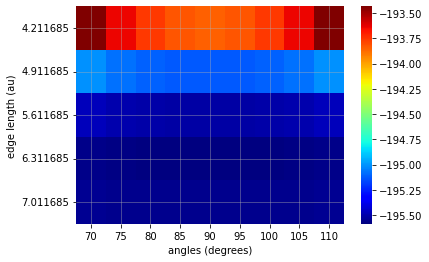

In [6]:
#As we can see from the heatmap of the differing unit cell energies, there does seem to be a bit of a convergence.
#However, the values for an edge length of 4.211685 au are very high and seem to make the other energies seem too
#small in comparison.
ax = sns.heatmap(data,cmap='jet')
ax.grid(which='both', alpha=0.5)
ax.set(xlabel='angles (degrees)', ylabel='edge length (au)')

In [7]:
#Let's remove the edge length that seems to have values that are too high and redraw the heatmap.
data2 = data.drop(index=[4.211685])
print(data2)

                 70          75          80          85          90   \
4.911685 -195.012794 -195.078479 -195.110565 -195.124397 -195.128140   
5.611685 -195.470924 -195.495511 -195.508060 -195.513054 -195.514246   
6.311685 -195.568603 -195.577691 -195.583338 -195.586055 -195.586831   
7.011685 -195.552475 -195.554622 -195.557011 -195.558594 -195.559150   

                 95          100         105         110  
4.911685 -195.124397 -195.110565 -195.078479 -195.012794  
5.611685 -195.513054 -195.508060 -195.495511 -195.470924  
6.311685 -195.586055 -195.583338 -195.577691 -195.568603  
7.011685 -195.558594 -195.557011 -195.554622 -195.552475  


[Text(0.5, 15.0, 'angles (degrees)'), Text(33.0, 0.5, 'edge length (au)')]

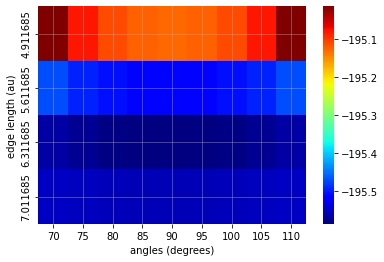

In [8]:
#From the heatmap below, the values around the actual unit cell dimensions (edge length of 6.311685 au) seem
#to be the lowest energy. The angular variation in energy is still a bit unclear, so let's try to see that.
ax = sns.heatmap(data2, cmap='jet')
ax.grid(which='both', alpha=0.5)
ax.set(xlabel='angles (degrees)', ylabel='edge length (au)')

[Text(0.5, 15.0, 'angles (degrees)'), Text(33.0, 0.5, 'edge length (au)')]

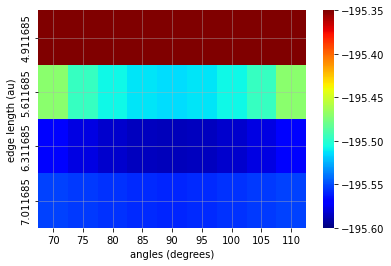

In [9]:
#Restrict the max values on the heatmap. We can now see the angular variation in energy.
#As shown here, it seems to all fall in towards a basin at the real crystal structure (6.311685 au and 90 degrees).
ax = sns.heatmap(data2, vmin=-195.6, vmax=-195.35, cmap='jet')
ax.grid(which='both', alpha=0.5)
ax.set(xlabel='angles (degrees)', ylabel='edge length (au)')

As we can see, The energy converges towards the lowest point at 90 degrees at every edge length. This is not surprising as 90 degrees is closest to the angle of the natural unit cell. As discussed with protein folding funnels, as you get closer in energy to the native structure, your energy lowers. We can see that in action here.

We can also see here that as the edge length gets closer to the native edge length (6.3116848019 au), the energy converges towards a basin. This matches our expectations.

And really, this is how evolutionary (and other crystal structure prediction) algorithms work in general. As you find lower and lower energy structures, your structures should match the actual crystal structure more and more. You funnel down this free energy surface towards the native unit cell like a protein folding to its native structure in a protein folding funnel.